# Analysis of cortical node model

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from network import NeuralNetwork
from logger import logger
from utils import *

t0 = time.perf_counter()

## Input parameters

In [3]:
# Drive parameters
drive_freqs = {  # presynaptic drive frequencies
    'baseline': 7, # Hz
    'high': 30,  # Hz
}
noise = 0.05  # noise factor

# Stimulus parameters
start = 250 # start time (ms)
dur = 150  # duration (ms)
Pref = 3e6  # reference pressure amplitude (Pa)
Pmax = 3.5e6  # maximum pressure amplitude (Pa)
Iref = pressure_to_intensity(Pref) / 1e4  # corresponding intensity (W/cm2)
Imax = pressure_to_intensity(Pmax) / 1e4  # corresponding intensity (W/cm2)
Isppa_range = np.linspace(0, Imax, 10)  # range of intensities to sweep

# List of sweep metrics to plot
sweep_metrics = [
    'ΔFR/FR',  # relative change in firing rate
]

# Simulation parameters
tstop = 700  # default simulation duration (ms)
nreps = 3  # number of repetitions per simulation (for sweep trends)

# Logging
paramsstr = {
    'drive': [
        f'baseline frequency = {drive_freqs["baseline"]} Hz',
        f'high frequency = {drive_freqs["high"]} Hz',
        f'noise factor = {noise}'],
    'stimulus': [
        f'start = {start} ms',
        f'duration = {dur} ms',
        f'P = {Pref * 1e-6:.1f} MPa <-> I = {Iref:.2f} W/cm2',
        f'range of intensities = {Isppa_range[0]:.2f} - {Isppa_range[-1]:.2f} W/cm2'],
    'simulation': [
        f'duration = {tstop} ms',
        f'number of repetitions (for sweeps) = {nreps}']
}
paramsstr = {k: '\n'.join([f'       - {x}' for x in v]) for k, v in paramsstr.items()}
paramsstr = '\n'.join([f'   - {k}:\n{v}' for k, v in paramsstr.items()]) 
logger.info('Input parameters:\n' + paramsstr)

 05/12/2023 07:21:33: Input parameters:
   - drive:
       - baseline frequency = 7 Hz
       - high frequency = 30 Hz
       - noise factor = 0.05
   - stimulus:
       - start = 250 ms
       - duration = 150 ms
       - P = 3.0 MPa <-> I = 278.22 W/cm2
       - range of intensities = 0.00 - 378.69 W/cm2
   - simulation:
       - duration = 700 ms
       - number of repetitions (for sweeps) = 3


## Initial model (no temperature dependence)

 05/12/2023 07:21:33: NeuralNetwork(1): created 1 node
 05/12/2023 07:21:33: NeuralNetwork(1): setting gMbar = 0 on node 0
 05/12/2023 07:21:33: NeuralNetwork(1): initialized
 05/12/2023 07:21:33: NeuralNetwork(1): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 278.2 W/cm2
 05/12/2023 07:21:33: NeuralNetwork(1): disabled currents: iM, iKT, iNaKPump


 05/12/2023 07:21:33: NeuralNetwork(1): simulating for 700.00 ms
 05/12/2023 07:21:33: NeuralNetwork(1): extracting output results
 05/12/2023 07:21:33: NeuralNetwork(1): max temperature increase:
    - node 0: ΔT = 3.7 °C
 05/12/2023 07:21:33: NeuralNetwork(1): number of spikes:
    - node 0: n = 0 spikes
 05/12/2023 07:21:33: NeuralNetwork(1): firing rate:
    - node 0: FR = N/A  Hz
 05/12/2023 07:21:33: NeuralNetwork(1): stimulus response:
    - node 0: ΔFR/FR = nan %
 05/12/2023 07:21:33: NeuralNetwork(1): plotting results
 05/12/2023 07:21:34: NeuralNetwork(1): removing stimulus
 05/12/2023 07:21:34: NeuralNetwork(1): setting pre-synaptic drive on nodes [0]
 05/12/2023 07:21:34: creating 7.0 ± 0.4 Hz pre-synaptic drive starting at 72.2 ms
 05/12/2023 07:21:34: NeuralNetwork(1): resetting pre-synaptic drive start times to 74.24 ms...
 05/12/2023 07:21:34: NeuralNetwork(1): disabled currents: iM, iKT, iNaKPump
 05/12/2023 07:21:34: NeuralNetwork(1): simulating for 700.00 ms
 05/12/2

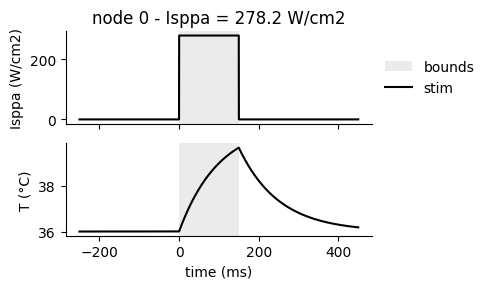

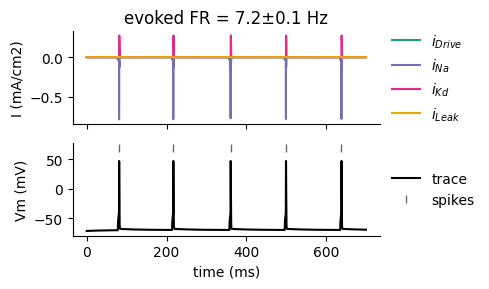

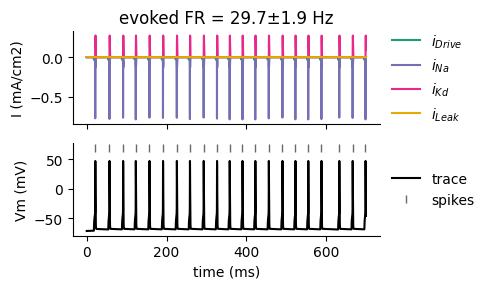

In [4]:
# Initialize model
model = NeuralNetwork(
    1,       # single node
    gMbar=0  # M-type K+ current disabled
)

# Set stimulus
model.set_stim(Iref, start=start, dur=dur)

# Run simulation and plot results of thermal model only
data = model.simulate(tstop=tstop)
fig = model.plot_results(data, include=['T'])

# Remove stimulus
model.remove_stim()

# For each baseline current, run simulation and plot results
for name, freq in drive_freqs.items():
    model.set_presyn_drive(freq=freq, noise=noise)
    data = model.simulate()
    mu_FR, err_FR = model.compute_metric(data, 'FR').loc['node0']
    FR_str = 'N/A' if mu_FR is None else f'{mu_FR:.1f}±{err_FR:.1f} Hz'
    fig = model.plot_results(data, exclude=['conductances', 'T'])
    fig.axes[0].set_title(f'evoked FR = {FR_str}')

# Reset stimulus
model.set_stim(Iref, start=start, dur=dur)

## Adding temperature-dependent components

### Q10 for gating kinetics

 05/12/2023 07:21:35: NeuralNetwork(1): setting Q10_rates = 3 on node 0
 05/12/2023 07:21:35: NeuralNetwork(1): resetting pre-synaptic drive start times to 17.32 ms...
 05/12/2023 07:21:35: NeuralNetwork(1): disabled currents: iM, iKT, iNaKPump


 05/12/2023 07:21:35: NeuralNetwork(1): simulating for 700.00 ms
 05/12/2023 07:21:35: NeuralNetwork(1): extracting output results
 05/12/2023 07:21:35: NeuralNetwork(1): max temperature increase:
    - node 0: ΔT = 3.7 °C
 05/12/2023 07:21:35: NeuralNetwork(1): number of spikes:
    - node 0: n = 21 spikes
 05/12/2023 07:21:35: NeuralNetwork(1): firing rate:
    - node 0: FR = 30.6 ±0.9 Hz
 05/12/2023 07:21:35: NeuralNetwork(1): stimulus response:
    - node 0: ΔFR/FR = 14.6 %
 05/12/2023 07:21:35: NeuralNetwork(1): plotting results


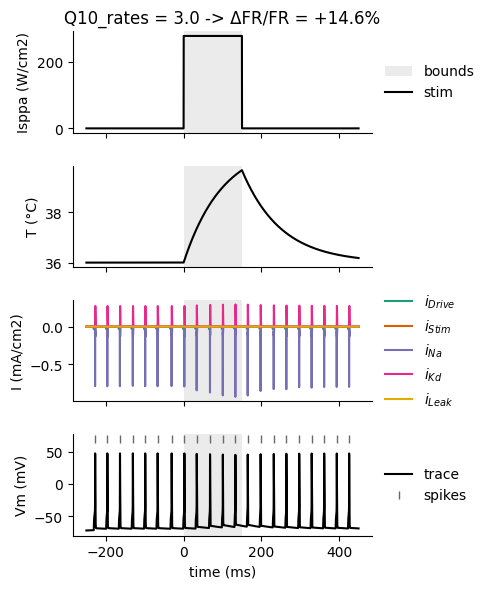

In [5]:
# Set Q10 coefficient for temperature dependence of gating transitions (Ganguly et al., 2019)
model.set_mech_param(Q10_rates=3)

# Run simulation and plot results
data = model.simulate()
resp = model.compute_metric(data, 'ΔFR/FR').loc['node0']
# FR_str = 'N/A' if mu_FR is None else f'{mu_FR:.1f}±{err_FR:.1f} Hz'
fig = model.plot_results(data, exclude='conductances')
fig.axes[0].set_title(f'Q10_rates = {model.Q10_rates:.1f} -> ΔFR/FR = {resp * 100:+.1f}%');

### Q10 for maximal channel conductances 

 05/12/2023 07:21:36: NeuralNetwork(1): setting Q10_gNa = 1.4 on node 0
 05/12/2023 07:21:36: NeuralNetwork(1): setting Q10_gKd = 4.75 on node 0
 05/12/2023 07:21:36: NeuralNetwork(1): resetting pre-synaptic drive start times to 16.35 ms...
 05/12/2023 07:21:36: NeuralNetwork(1): disabled currents: iM, iKT, iNaKPump


 05/12/2023 07:21:36: NeuralNetwork(1): simulating for 700.00 ms
 05/12/2023 07:21:36: NeuralNetwork(1): extracting output results
 05/12/2023 07:21:36: NeuralNetwork(1): max temperature increase:
    - node 0: ΔT = 3.7 °C
 05/12/2023 07:21:36: NeuralNetwork(1): number of spikes:
    - node 0: n = 21 spikes
 05/12/2023 07:21:36: NeuralNetwork(1): firing rate:
    - node 0: FR = 30.2 ±1.3 Hz
 05/12/2023 07:21:36: NeuralNetwork(1): stimulus response:
    - node 0: ΔFR/FR = -13.7 %
 05/12/2023 07:21:36: NeuralNetwork(1): plotting results


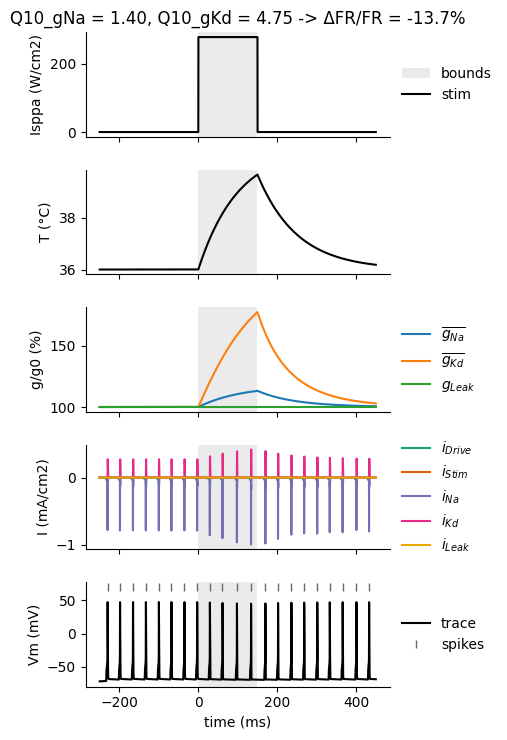

In [6]:
# Set Q10 coefficient for temperature dependence iNa and iKd maximal conductances (Ganguly et al., 2019)
model.set_mech_param(
    Q10_gNa=1.40,  # approximative fit to Fig. S1D in Ganguly et al., 2019
    Q10_gKd=4.75,  # approximative fit to Fig. S1D in Ganguly et al., 2019
)

# Run simulation and plot results
data = model.simulate()
resp = model.compute_metric(data, 'ΔFR/FR').loc['node0']
FR_str = 'N/A' if mu_FR is None else f'{mu_FR:.1f}±{err_FR:.1f} Hz'
fig = model.plot_results(data, gmode='rel')
fig.axes[0].set_title(f'Q10_gNa = {model.Q10_gNa:.2f}, Q10_gKd = {model.Q10_gKd:.2f} -> ΔFR/FR = {resp * 100:+.1f}%');

### Na-K pump with temperature-dependent conductance

 05/12/2023 07:21:37: NeuralNetwork(1): setting gNaKPump = 7e-06 on node 0
 05/12/2023 07:21:37: NeuralNetwork(1): setting Q10_gNaK = 1.88 on node 0
 05/12/2023 07:21:37: NeuralNetwork(1): resetting pre-synaptic drive start times to 16.22 ms...
 05/12/2023 07:21:37: NeuralNetwork(1): disabled currents: iM, iKT


 05/12/2023 07:21:37: NeuralNetwork(1): simulating for 700.00 ms
 05/12/2023 07:21:37: NeuralNetwork(1): extracting output results
 05/12/2023 07:21:37: NeuralNetwork(1): max temperature increase:
    - node 0: ΔT = 3.7 °C
 05/12/2023 07:21:37: NeuralNetwork(1): number of spikes:
    - node 0: n = 0 spikes
 05/12/2023 07:21:37: NeuralNetwork(1): firing rate:
    - node 0: FR = N/A  Hz
 05/12/2023 07:21:37: NeuralNetwork(1): stimulus response:
    - node 0: ΔFR/FR = nan %
 05/12/2023 07:21:37: NeuralNetwork(1): plotting results
 05/12/2023 07:21:37: NeuralNetwork(1): setting gNaKPump = 1e-07 on node 0
 05/12/2023 07:21:37: NeuralNetwork(1): resetting pre-synaptic drive start times to 15.88 ms...
 05/12/2023 07:21:37: NeuralNetwork(1): disabled currents: iM, iKT
 05/12/2023 07:21:37: NeuralNetwork(1): simulating for 700.00 ms
 05/12/2023 07:21:37: NeuralNetwork(1): extracting output results
 05/12/2023 07:21:38: NeuralNetwork(1): max temperature increase:
    - node 0: ΔT = 3.7 °C
 05/12

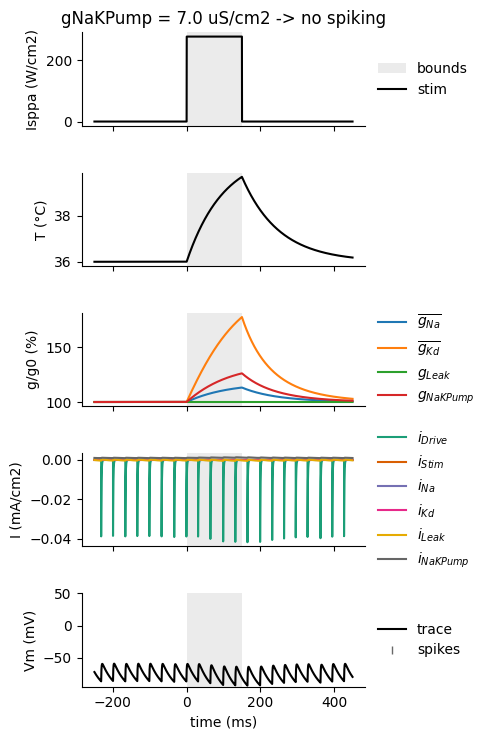

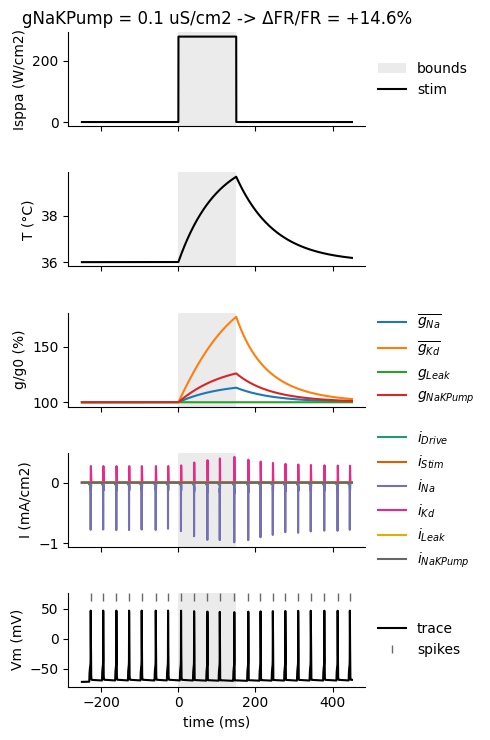

In [7]:
# Add temperature-dependent NaK pump conductance (Ganguly et al., 2019)
model.set_mech_param(
    gNaKPump=7e-6,  # from Ganguly et al., 2019
    Q10_gNaK=1.88  # from Ganguly et al., 2019 
)

# Run simulation and plot results
data = model.simulate()
resp = model.compute_metric(data, 'ΔFR/FR').loc['node0']
fig = model.plot_results(data, gmode='rel')
fig.axes[0].set_title(f'gNaKPump = {model.gNaKPump * 1e6:.1f} uS/cm2 -> no spiking');

# Decrease baseline gNaK conductance to prevent impact on spontaneous spiking
model.set_mech_param(gNaKPump=1e-7)

# Run simulation and plot results
data = model.simulate()
resp = model.compute_metric(data, 'ΔFR/FR').loc['node0']
fig = model.plot_results(data, gmode='rel')
fig.axes[0].set_title(f'gNaKPump = {model.gNaKPump * 1e6:.1f} uS/cm2 -> ΔFR/FR = {resp * 100:+.1f}%');

# Remove gNaK current for further analyses
model.set_mech_param(gNaKPump=0)

### Thermally-activated K+ current

 05/12/2023 07:21:39: NeuralNetwork(1): setting gKT = 2.4495e-06 on node 0
 05/12/2023 07:21:39: NeuralNetwork(1): resetting pre-synaptic drive start times to 17.46 ms...
 05/12/2023 07:21:39: NeuralNetwork(1): disabled currents: iM, iNaKPump


 05/12/2023 07:21:39: NeuralNetwork(1): simulating for 700.00 ms
 05/12/2023 07:21:39: NeuralNetwork(1): extracting output results
 05/12/2023 07:21:39: NeuralNetwork(1): max temperature increase:
    - node 0: ΔT = 3.7 °C
 05/12/2023 07:21:39: NeuralNetwork(1): number of spikes:
    - node 0: n = 21 spikes
 05/12/2023 07:21:39: NeuralNetwork(1): firing rate:
    - node 0: FR = 29.9 ±1.3 Hz
 05/12/2023 07:21:39: NeuralNetwork(1): stimulus response:
    - node 0: ΔFR/FR = 14.6 %
 05/12/2023 07:21:39: NeuralNetwork(1): plotting results
 05/12/2023 07:21:39: NeuralNetwork(1): setting gKT = 4.899e-06 on node 0
 05/12/2023 07:21:39: NeuralNetwork(1): resetting pre-synaptic drive start times to 17.14 ms...
 05/12/2023 07:21:39: NeuralNetwork(1): disabled currents: iM, iNaKPump
 05/12/2023 07:21:39: NeuralNetwork(1): simulating for 700.00 ms
 05/12/2023 07:21:40: NeuralNetwork(1): extracting output results
 05/12/2023 07:21:40: NeuralNetwork(1): max temperature increase:
    - node 0: ΔT = 3.

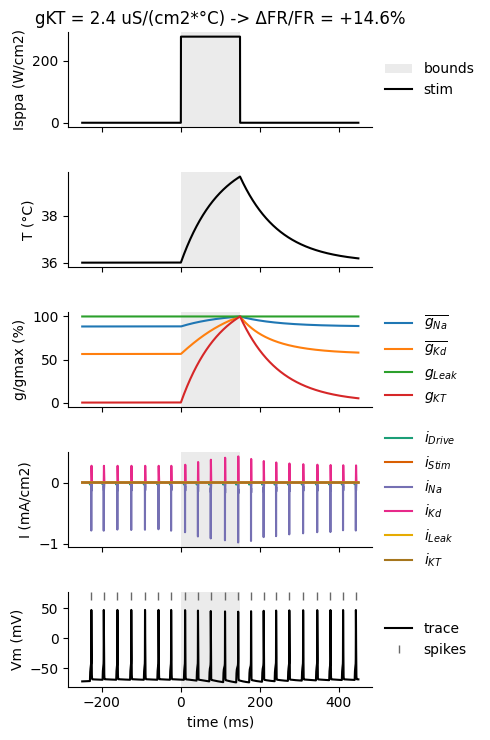

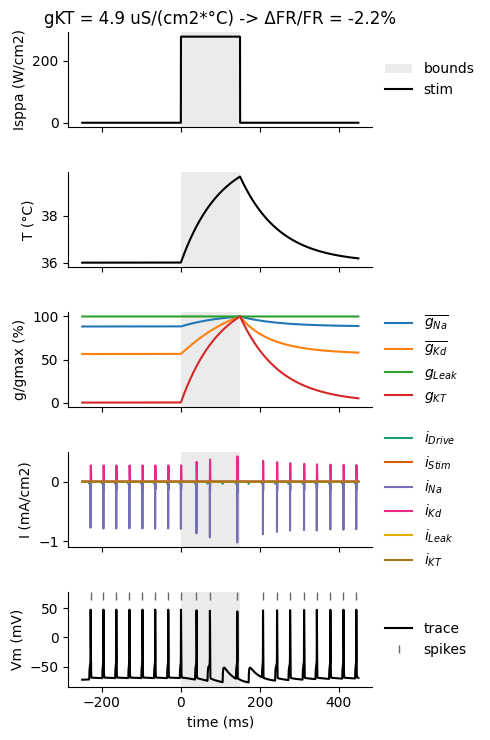

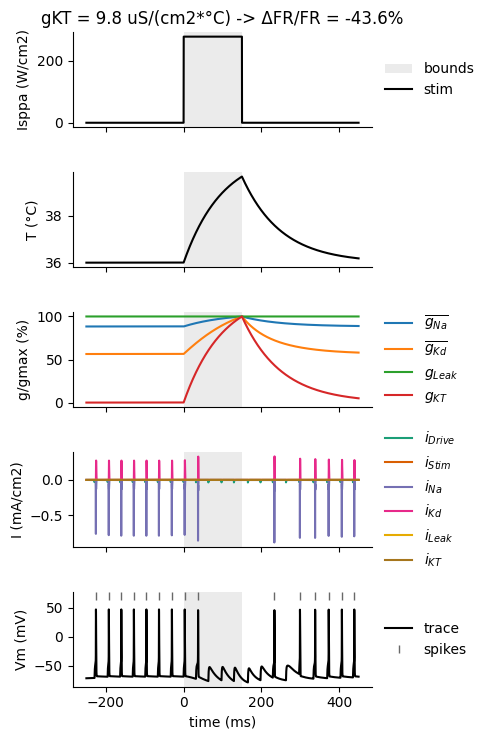

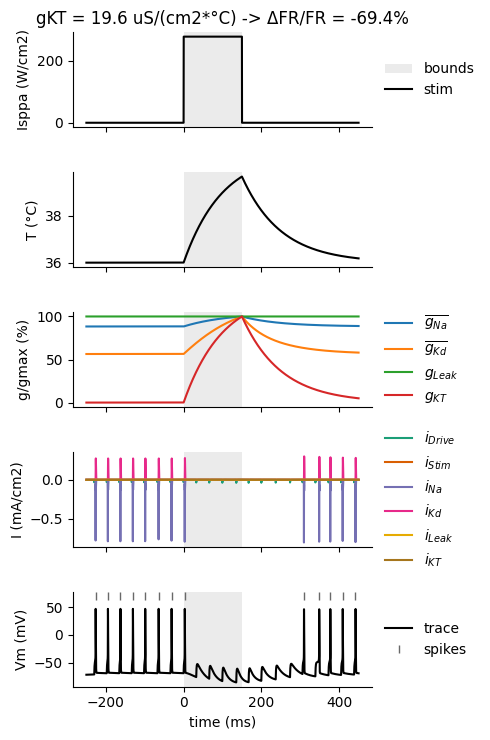

In [8]:
# Compute temperature-dependent K+ current conductance increase per degree Celsius
GKT = 0.58e-9  # KT conductance increase per ΔT (S/°C), extracted from Owen et al., 2019
gKT = GKT / (model.Acell * model.UM_TO_CM**2)  # KT conductance increase per ΔT (S/(cm2*°C))
gKT = np.round(gKT, 9)  # round to 9 digits

# Define a bunch of gKT values to test, based on this reference value
gKT_range = np.array([0.5, 1, 2, 4]) * gKT

# For each gKT value, run simulation and plot results
for x in gKT_range:
    model.set_mech_param(gKT=x)
    data = model.simulate()
    resp = model.compute_metric(data, 'ΔFR/FR').loc['node0']
    fig = model.plot_results(data, gmode='norm')
    fig.axes[0].set_title(f'gKT = {model.gKT * 1e6:.1f} uS/(cm2*°C) -> ΔFR/FR = {resp * 100:+.1f}%');

# Reset gKT to reference value
model.set_mech_param(gKT=gKT)

## Visualize inhibition across the intensity range

 05/12/2023 07:21:43: NeuralNetwork(1): setting gKT = 2.4495e-06 on node 0
 05/12/2023 07:21:43: NeuralNetwork(1): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

 05/12/2023 07:21:50: NeuralNetwork(1): setting gKT = 4.899e-06 on node 0
 05/12/2023 07:21:50: NeuralNetwork(1): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

 05/12/2023 07:21:56: NeuralNetwork(1): setting gKT = 9.798e-06 on node 0
 05/12/2023 07:21:56: NeuralNetwork(1): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

 05/12/2023 07:22:03: NeuralNetwork(1): setting gKT = 1.9596e-05 on node 0
 05/12/2023 07:22:03: NeuralNetwork(1): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


 05/12/2023 07:22:12: NeuralNetwork(1): setting gKT = 4.899e-06 on node 0
 05/12/2023 07:22:12: NeuralNetwork(1): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 278.2 W/cm2


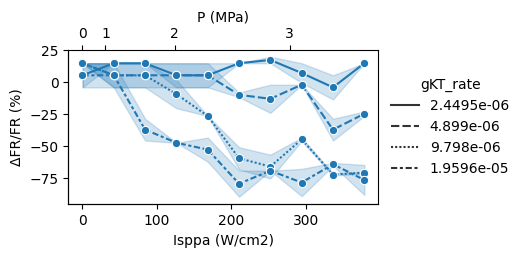

In [9]:
# For each value of gKT, run sweep for Isppa range
data = []
for g in gKT_range:
    model.set_mech_param(gKT=g)
    data.append(model.run_stim_sweep(Isppa_range, nreps=nreps))
data = pd.concat(data, axis=0, keys=gKT_range, names=['gKT_rate'])

# Plot metrics vs Isppa, for each value of gKT
fig = model.plot_sweep_results(data, sweep_metrics)

# Reset gKT and stimulus amplitude to reference values
model.set_mech_param(gKT=gKT)
model.set_stim(Iref)

## Adding intensity-dependent excitation component

 05/12/2023 09:35:42: NeuralNetwork(1): setting pre-synaptic drive on nodes [0]
 05/12/2023 09:35:42: modifying pre-synaptic drive on node 0
 05/12/2023 09:35:42: creating 7.0 ± 0.4 Hz pre-synaptic drive starting at 74.5 ms
 05/12/2023 09:35:42: NeuralNetwork(1): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 50.0 W/cm2
 05/12/2023 09:35:42: NeuralNetwork(1): resetting pre-synaptic drive start times to 74.68 ms...
 05/12/2023 09:35:42: NeuralNetwork(1): disabled currents: iM, iNaKPump
 05/12/2023 09:35:42: NeuralNetwork(1): simulating for 700.00 ms
 05/12/2023 09:35:43: NeuralNetwork(1): extracting output results
 05/12/2023 09:35:43: NeuralNetwork(1): max temperature increase:
    - node 0: ΔT = 0.7 °C
 05/12/2023 09:35:43: NeuralNetwork(1): number of spikes:
    - node 0: n = 5 spikes
 05/12/2023 09:35:43: NeuralNetwork(1): firing rate:
    - node 0: FR = 6.8 ±0.4 Hz
 05/12/2023 09:35:43: NeuralNetwork(1): stimulus response:
    - node 0: ΔFR/FR = -8.3 %
 05/

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


 05/12/2023 09:35:57: NeuralNetwork(1): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 278.2 W/cm2


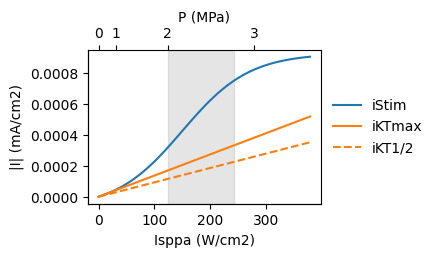

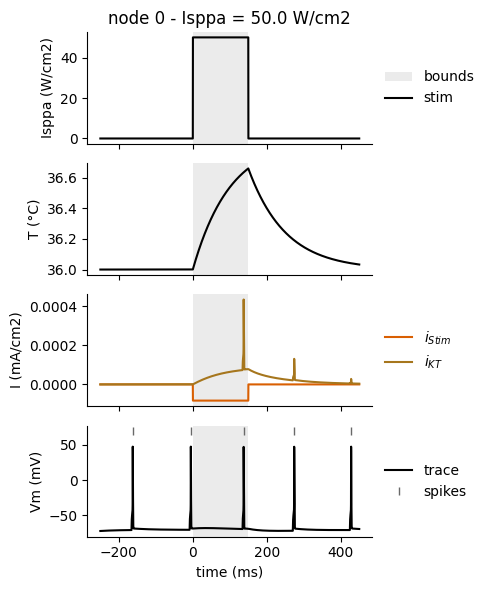

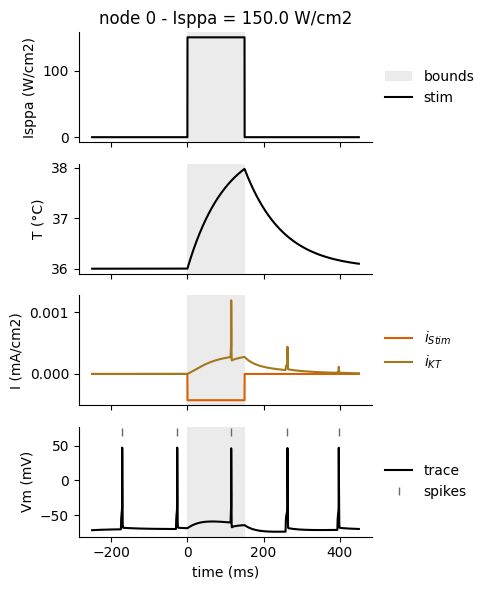

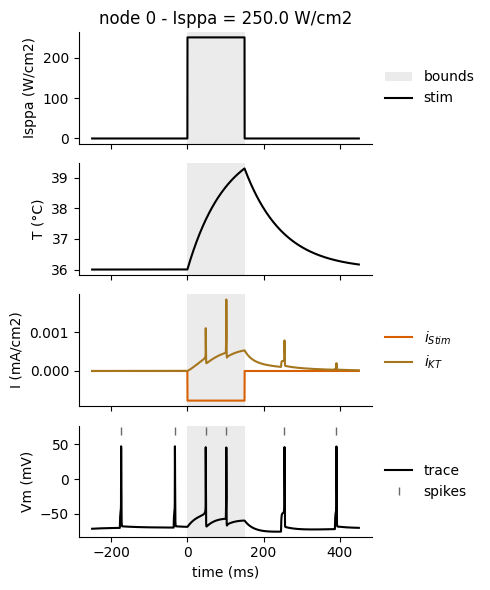

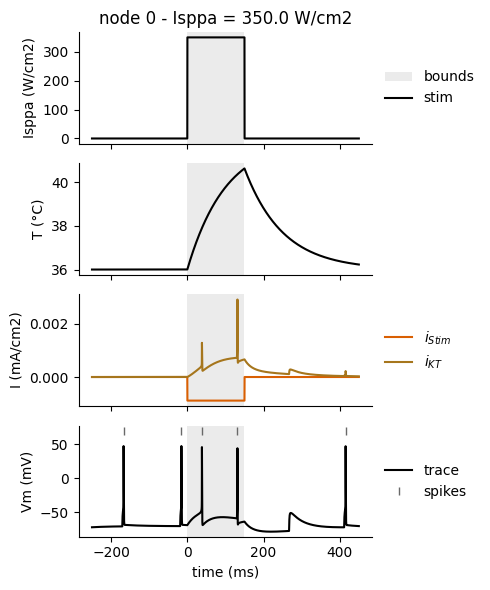

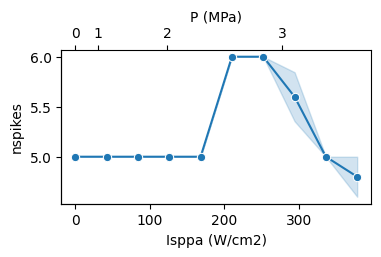

In [22]:
# Reset presynaptic drive to "baseline" value
model.set_presyn_drive(freq=drive_freqs['baseline'], noise=noise)

# Set stimulus drive parameters
istim_params = dict(
    iStimbar=1e-3,  # mA/cm2
    iStimx0=150,  # W/cm2
    iStimdx=60,  # W/cm2
)
model.set_mech_param(**istim_params)

# Plot E/I currents imbalance over stimulus intensity range
Irange_dense = np.linspace(Isppa_range[0], Isppa_range[-1], 100)
fig = model.plot_EI_imbalance(Irange_dense, add_Pmap=True)
ax = fig.axes[0]

# Add experimental range of single-node response curve
Pexp = np.array([2, 2.8]) * 1e6  # pressure bounds of experimental range (Pa)
Iexp = pressure_to_intensity(Pexp) / 1e4
ax.axvspan(*Iexp, color='gray', alpha=0.2);

# For a few sampled values of Isppa
Irange_sparse = np.array([50, 150, 250, 350], dtype=float)  # W/cm2
for Isppa in Irange_sparse:
    # # Indicate sample value on E/I plot
    # ax.axvline(Isppa, color='k', linestyle='--')

    # Run simulation and plot results
    model.set_stim(Isppa)
    data = model.simulate()
    fig = model.plot_results(data, gmode='rel', exclude=['iNa', 'iKd', 'iLeak', 'iDrive', 'conductances'])
 
# Run sweep simulation and plot results
data = model.run_stim_sweep(Isppa_range, nreps=5)
fig = model.plot_sweep_results(data, ['nspikes'])

# Reset stimulus amplitude to reference value
model.set_stim(Iref)

## Visualize E/I imbalance across the intensity range

In [11]:
# # Sweeps parameters
# sweep_params =  {
#     'iStimbar': np.linspace(2e-4, 1e-3, 3).round(4),  # mA/cm2
#     'iStimx0': np.linspace(50, 350, 3),  # W/cm2
#     'iStimdx': np.round(np.logspace(1, 2, 3)),  # W/cm2
# }

# # For each sweep parameter
# for k, values, in sweep_params.items():
#     # Extract parameter default value
#     v0 = model.get_mech_param(k)
#     # Initialize figure to plot E/I imbalance
#     EIfig, EIaxes = plt.subplots(1, len(values), figsize=(3 * len(values), 3))
#     # Initialize empty data list
#     data = []
#     # For each value of parameter
#     for ival, (v, EIax) in enumerate(zip(values, EIaxes)):
#         # Set model parameter to current value
#         model.set_mech_param(**{k: v})
#         # Plot EI imbalance on appropriate axis
#         fig = model.plot_EI_imbalance(
#             Irange_dense, ax=EIax, add_Pmap=True, legend=ival == len(values) - 1)
#         EIax.set_title(f'{k} = {v}')
#         if ival > 0:
#             EIax.set_ylabel('')
#         # Run sweep for Isppa range
#         data.append(model.run_stim_sweep(Isppa_range, nreps=nreps))
#     # Reset parameter to default value
#     model.set_mech_param(**{k: v0})
#     # Adjust EI figure layout
#     EIfig.tight_layout()
#     # Concatenate data for all values of parameter
#     data = pd.concat(data, axis=0, keys=values, names=[k])
#     # Plot metrics vs Isppa, for each value of gKT
#     fig = model.plot_sweep_results(data, sweep_metrics)

# # Reset stimulus amplitude to reference value
# model.set_stim(Iref)

 04/12/2023 23:26:24: NeuralNetwork(1): setting pre-synaptic drive on nodes [0]
 04/12/2023 23:26:24: modifying pre-synaptic drive on node 0
 04/12/2023 23:26:24: creating 7.0 ± 0.4 Hz pre-synaptic drive starting at 0.0 ms
 04/12/2023 23:26:24: NeuralNetwork(1): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


 04/12/2023 23:26:47: NeuralNetwork(1): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 278.2 W/cm2


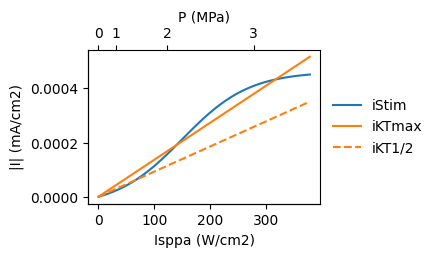

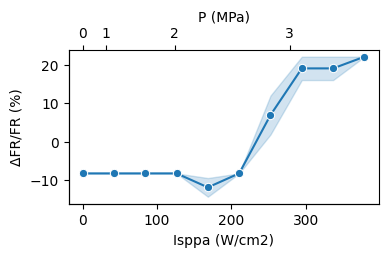

In [32]:
# Set stimulus drive parameters
model.set_mech_param(
    iStimbar=5e-4,  # mA/cm2
    iStimx0=150,  # W/cm2
    iStimdx=60,  # W/cm2
)

# Plot E/I imbalance
fig = model.plot_EI_imbalance(Irange_dense)

# Run simulation and plot results
data = model.run_stim_sweep(Isppa_range, nreps=10)
fig = model.plot_sweep_results(data, sweep_metrics)

# Reset stimulus amplitude to reference value
model.set_stim(Iref)

## Log completion

In [13]:
logger.info(f'notebook completed in {timedelta(seconds=time.perf_counter() - t0)}')

 04/12/2023 22:38:04: notebook completed in 0:01:51.589536
